# **Polish coins detection using transfer learning for small dataset**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,ZeroPadding2D, BatchNormalization
from tensorflow.keras import regularizers

In [22]:
!nvidia-smi

Sat Apr  3 13:36:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |  15327MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
#Basic variables
width = 224
height = 224
num_classes = 9
num_batches = 32
learning_rate = 0.0001
validation_split = 0.15
epochs = 200
seed = 123
dataset_path = '../input/small-polish-monetary/small'

In [6]:
#Image generators for both train and validation sets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    validation_split = validation_split,
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = validation_split,
)

In [9]:
#Load data from 
train_dataset = train_datagen.flow_from_directory(
    dataset_path, 
    batch_size = num_batches, 
    target_size = (width, height), 
    subset = "training", 
    seed = seed
)

validation_dataset = val_datagen.flow_from_directory(
    dataset_path, 
    batch_size = num_batches, 
    target_size = (width, height), 
    subset = "validation", 
    seed = seed
)

Found 676 images belonging to 9 classes.
Found 114 images belonging to 9 classes.


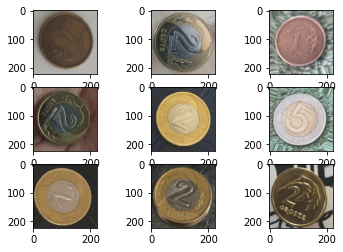

In [46]:
#Show some random images from train dataset
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(train_dataset[0][0][i])

In [12]:
#Create base xception model and output layer on top of it

base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

#First freeze xception model parameters and learn only output weights
for layer in base_model.layers:
  layer.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [23]:
#Compile model
optimizer = keras.optimizers.Adam(learning_rate)
loss = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy","Recall", "Precision"])

In [24]:
#Create callbacks: EarlyStopping to prevent overfitting and checkpoints to save models. We try to maximize validation dataset accuracy
checkpoints = keras.callbacks.ModelCheckpoint("mode.h5", monitor='val_accuracy', mode="max")
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode="max", patience=5)

In [25]:
#Train model and save history
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,callbacks=[checkpoints, earlystop])

Epoch 1/200
22/22 [==============================] - 29s 1s/step - loss: 2.2669 - accuracy: 0.1286 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 2.1493 - val_accuracy: 0.1754 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/200
22/22 [==============================] - 17s 785ms/step - loss: 2.0430 - accuracy: 0.2782 - recall: 4.2149e-04 - precision: 0.2609 - val_loss: 2.0088 - val_accuracy: 0.2719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/200
22/22 [==============================] - 16s 746ms/step - loss: 1.9156 - accuracy: 0.3694 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.8894 - val_accuracy: 0.4211 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/200
22/22 [==============================] - 17s 766ms/step - loss: 1.7775 - accuracy: 0.4919 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.7824 - val_accuracy: 0.4912 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/200
22/22 [====================

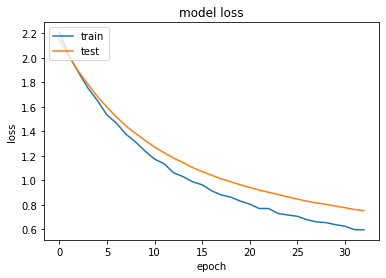

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

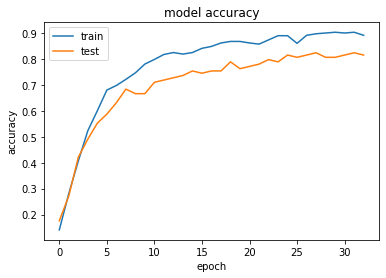

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
model.evaluate(validation_dataset)

4/4 [==============================] - 1s 293ms/step - loss: 0.7519 - accuracy: 0.8158 - recall: 0.5439 - precision: 0.9538


[0.751867949962616, 0.8157894611358643, 0.5438596606254578, 0.9538461565971375]

In [31]:
model.evaluate(train_dataset)

22/22 [==============================] - 14s 636ms/step - loss: 0.5831 - accuracy: 0.9112 - recall: 0.6568 - precision: 0.9867


[0.5831462144851685,
 0.9112426042556763,
 0.6568047404289246,
 0.9866666793823242]

In [32]:
#Lets try to unfreeze more layers
for layers in base_model.layers:
    layers.trainable = True

#Gonna use smaller learning rate
optimizer = keras.optimizers.Adam(0.00001)
loss = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy","Recall", "Precision"])

In [33]:
#Train model and save history
history_finetune = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,callbacks=[checkpoints, earlystop])

Epoch 1/200
22/22 [==============================] - 25s 931ms/step - loss: 1.4554 - accuracy: 0.5457 - recall: 0.1700 - precision: 0.9318 - val_loss: 0.6221 - val_accuracy: 0.8333 - val_recall: 0.6140 - val_precision: 0.9589
Epoch 2/200
22/22 [==============================] - 19s 855ms/step - loss: 1.1518 - accuracy: 0.6691 - recall: 0.3412 - precision: 0.9704 - val_loss: 0.5457 - val_accuracy: 0.8509 - val_recall: 0.7105 - val_precision: 0.9529
Epoch 3/200
22/22 [==============================] - 19s 870ms/step - loss: 0.9252 - accuracy: 0.7800 - recall: 0.4617 - precision: 0.9688 - val_loss: 0.4875 - val_accuracy: 0.8596 - val_recall: 0.7632 - val_precision: 0.9457
Epoch 4/200
22/22 [==============================] - 19s 867ms/step - loss: 0.8201 - accuracy: 0.7873 - recall: 0.5252 - precision: 0.9755 - val_loss: 0.4387 - val_accuracy: 0.8860 - val_recall: 0.8158 - val_precision: 0.9588
Epoch 5/200
22/22 [==============================] - 19s 844ms/step - loss: 0.5738 - accuracy: 0

In [44]:
model.save('monetary.h5')

In [35]:
model.evaluate(validation_dataset)

4/4 [==============================] - 1s 297ms/step - loss: 0.0883 - accuracy: 0.9825 - recall: 0.9737 - precision: 0.9911


[0.08825396001338959,
 0.9824561476707458,
 0.9736841917037964,
 0.9910714030265808]

In [37]:
model.evaluate(train_dataset)

22/22 [==============================] - 15s 671ms/step - loss: 0.0177 - accuracy: 1.0000 - recall: 0.9985 - precision: 1.0000


[0.017705820500850677, 1.0, 0.9985207319259644, 1.0]

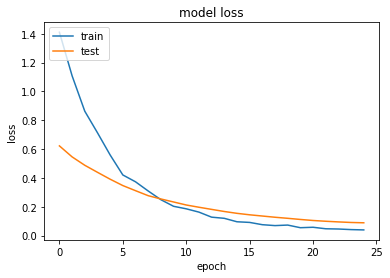

In [38]:
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

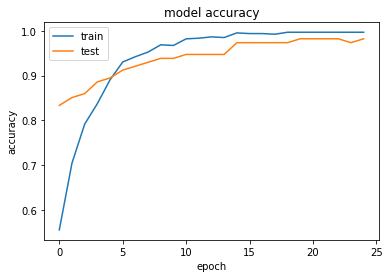

In [39]:
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()